Reference: https://huggingface.co/facebook/detr-resnet-50

# Import Necessary Packages

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from transformers import DetrForObjectDetection, DetrImageProcessor


# Load the Model

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection, DetrConfig

### 역자 추가 코드: config를 명시적으로 정의
config = DetrConfig.from_pretrained("facebook/detr-resnet-50")

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", config=config)
model.eval()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

# Get Image from Internet

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### 역자 주: 아래 url이 접속되지 않아 코드 수정
"""
# 원서의 코드
url = "https://raw.githubusercontent.com/bpbpublications/Building-Transformer-Models-with-PyTorch/main/chapter7/tulip_field.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.convert("RGB")
"""
### 이하 역자 수정 코드
# Ch7/tulip_field.png 파일을 자신의 구글 드라이브에 업로드 후 그 경로를 사용
img_path = '/content/drive/MyDrive/Book6/Ch7/tulip_field.png'

# 이미지 열기
img = Image.open(img_path)

# RGB로 변환
img = img.convert("RGB")

In [ ]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
img_tensor = transform(img).unsqueeze(0)

# Perform the Prediction

In [ ]:
# 역자 주: 책의 코드 순서와 아래코드 블록은 코드내 위치가 다릅니다.
# 하지만 실행 결과는 같습니다.
with torch.no_grad():
    outputs = model(img_tensor)
target_sizes = torch.tensor([img.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]


# Plot the Prediction

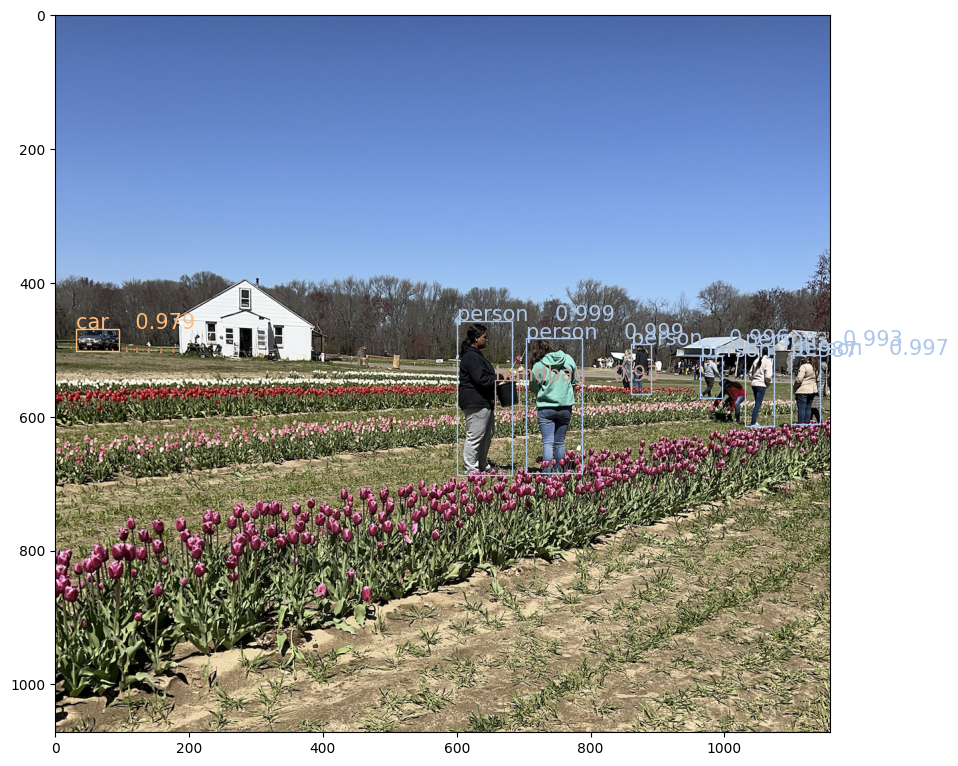

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img)

# get_cmap("tab20")은 20개의 색상을 지닌 컬러맵으로
# 이미지의 개별 객체 카테고리에 고유의 색상을 배정
colors = plt.get_cmap("tab20").colors

# results["scores"]는 예측
# results["labels"]는 true 레이블
# results["boxes"]는 객체의 경계 상자
for score, label, box in zip(results["scores"], results["labels"],
                             results["boxes"]):
    x, y, w, h = box
    w = w - x
    h = h - y
    rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor=colors[label % 20], facecolor="none")
    ax.add_patch(rect)
    ax.text(x, y, f"{model.config.id2label[label.item()]}\
    {round(score.item(), 3)}", fontsize=15, color=colors[label % 20])

plt.show()